# Named axes and easy-to-revise parallelism with `xmap`

This tutorial introduces `jax.xmap` and the named-axis programming model that comes with it. By reading this, you'll learn how to write error-avoiding, self-documenting functions using named axes, then control how they're executed on hardware at any scale, from your laptop CPU to the largest TPU supercomputer.

We start with a toy neural network example.

---
> **xmap is an experimental API. Expect rough edges and changes in the future!**
---

## From positions to names in a toy neural network

Presentations on JAX often start with a simple neural network prediction function and loss, written in pure NumPy. Here's a simple network with one hidden layer:

In [ ]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8' # Use 8 CPU devices

In [ ]:
import jax.numpy as jnp
from jax import lax
from jax.nn import one_hot, relu
from jax.scipy.special import logsumexp

def predict(w1, w2, images):
  hiddens = relu(jnp.dot(images, w1))
  logits = jnp.dot(hiddens, w2)
  return logits - logsumexp(logits, axis=1, keepdims=True)

def loss(w1, w2, images, labels):
  predictions = predict(w1, w2, images)
  targets = one_hot(labels, predictions.shape[-1])
  losses = jnp.sum(targets * predictions, axis=1)
  return -jnp.mean(losses, axis=0)

We can then initialize inputs with the right shapes and compute the loss value:

In [ ]:
w1 = jnp.zeros((784, 512))
w2 = jnp.zeros((512, 10))
images = jnp.zeros((128, 784))
labels = jnp.zeros(128, dtype=jnp.int32)

print(loss(w1, w2, images, labels))

Here's how we might write the same function using named axes. Don't worry if you can't follow the API details. They are not important now and we will explain everything step-by-step afterwards. This is just to show you what you can do with xmap before you learn them!

In [ ]:
def named_predict(w1, w2, image):
  hidden = relu(lax.pdot(image, w1, 'inputs'))
  logits = lax.pdot(hidden, w2, 'hidden')
  return logits - logsumexp(logits, 'classes')

def named_loss(w1, w2, images, labels):
  predictions = named_predict(w1, w2, images)
  num_classes = lax.psum(1, 'classes')
  targets = one_hot(labels, num_classes, axis='classes')
  losses = lax.psum(targets * predictions, 'classes')
  return -lax.pmean(losses, 'batch')

This code is simpler: we don't need to worry about axis order when calling functions like `jnp.dot`, or remember which axis position to reduce over with `logsumexp`, `jnp.sum`, or `jnp.mean`.

But the real win is that names let us use `xmap` to control our function's execution. At its simplest, `xmap` will just vectorize over all named axes, so that the function is executed just like its positional-axis counterpart:

In [ ]:
from jax.experimental.maps import xmap

in_axes = [['inputs', 'hidden', ...],
           ['hidden', 'classes', ...],
           ['batch', 'inputs', ...],
           ['batch', ...]]

loss = xmap(named_loss, in_axes=in_axes, out_axes=[...])
print(loss(w1, w2, images, labels))

But on a whim we can decide to parallelize over the batch axis:

In [ ]:
import jax
import numpy as np
from jax.sharding import Mesh

loss = xmap(named_loss, in_axes=in_axes, out_axes=[...],
            axis_resources={'batch': 'x'})

devices = np.array(jax.local_devices())
with Mesh(devices, ('x',)):
  print(loss(w1, w2, images, labels))

Or we might want to perform model parallelism over the hidden axis:

In [ ]:
loss = xmap(named_loss, in_axes=in_axes, out_axes=[...],
            axis_resources={'hidden': 'x'})

devices = np.array(jax.local_devices())
with Mesh(devices, ('x',)):
  print(loss(w1, w2, images, labels))

Or we might want to do both model and batch data parallelism at once:

In [ ]:
loss = xmap(named_loss, in_axes=in_axes, out_axes=[...],
            axis_resources={'batch': 'x', 'hidden': 'y'})

devices = np.array(jax.local_devices()).reshape((4, 2))
with Mesh(devices, ('x', 'y')):
  print(loss(w1, w2, images, labels))

With `xmap`, we can revise our parallelism strategy on a dime, without needing to rewrite our neural network function.

## Preliminaries

In [ ]:
import jax.numpy as jnp
from jax import lax
from functools import partial
import jax
import numpy as np

To better illustrate the new programming model, we make extensive use of custom type annotations in this notebook. The annotations have no effect on how the code evaluates and will be unchecked for now.

In [ ]:
from typing import Any, Callable

class ArrayType:
  def __getitem__(self, idx):
    return Any
f32 = ArrayType()
i32 = ArrayType()

## Tensors with named axes

The NumPy programming model is based around nd-arrays. Each nd-array can be associated with a two-component type:
* the element type (accessible via the `.dtype` attribute)
* shape (a tuple of integers given by `.shape`).

Using our little type annotation language, we will write these types as `dtype[shape_tuple]`.

> For example, a 5x7x4 array of 32-bit floating point numbers will be denoted as `f32[(5, 7, 4)]`.

Here is a small example that shows how the annotations can demonstrate the way shapes propagate through a simple NumPy program:

In [ ]:
x: f32[(2, 3)] = np.ones((2, 3), dtype=np.float32)
y: f32[(3, 5)] = np.ones((3, 5), dtype=np.float32)
z: f32[(2, 5)] = x.dot(y)  # matrix multiplication
w: f32[(7, 1, 5)] = np.ones((7, 1, 5), dtype=np.float32)
q: f32[(7, 2, 5)] = z + w  # broadcasting

The extension we propose is to add another component of array type: a `named_shape`, mapping axis names (arbitrary hashable objects, with strings being a common choice) to integer sizes. Most importantly, because each axis has a name, their order has no meaning. That is, a named shape of `{'a': 2, 'b': 5}` is indistinguishable from a named shape of `{'b': 5, 'a': 2}`.

> This is not an entirely new idea. Some good examples of where using named axes has been proposed in the past are: [Mesh TensorFlow](https://github.com/tensorflow/mesh), [Tensor Considered Harmful](http://nlp.seas.harvard.edu/NamedTensor) manifesto as well as the [xarray](http://xarray.pydata.org/en/stable/) and [einops](http://einops.rocks/) packages. Keep in mind that many of those are slightly different in that they do assign an order to the named axes, but they are unordered in JAX.

From now on we will allow the type annotations to have two components, the first one still being the value's `.shape`, while the second one will be the `.named_shape`.

In [ ]:
e: f32[(5, 7), {'batch': 20, 'sequence': 30}]
# e.shape == (5, 7)
# e.named_shape == {'batch': 20, 'sequence': 30} == {'sequence': 30, 'batch': 20}

While we don't modify the meaning of `.ndim` (which is always equal to `len(shape)`) and `.size` (equal to the product of `shape`), we do so solely for backward-compatibility reasons. The true rank of an array that has non-empty named axes is `len(shape) + len(named_shape)`. The true number of elements stored in such an array is equal to the product of sizes of all dimensions, both positional and named.

## Introducing and eliminating named axes

But how does one create such arrays, if all top-level JAX operations work in the NumPy model with purely positional axes? While this constraint could be lifted at some point, for the time being the only way to introduce named axes is to use `xmap`.

`xmap` can be thought of as an adapter that takes in arrays with positional axes, makes some of them named (as specified by `in_axes`), and calls the function that it wraps. Once the wrapped function returns arrays, all named axes appearing in those are converted back to positional axes (as specified by `out_axes`).

`in_axes` should have a structure that matches the signature of the `xmap`ped function arguments, except with all places where array arguments would be replaced by an _axis mapping_. There are two ways in which axis mappings can be specified:
* as dictionaries mapping positional axes to axis names (e.g. `{0: 'x', 2: 'y'}`); and
* as lists of axis names terminated by the ellipsis object (e.g. `['a', 'b', ...]`), indicating that a prefix of positional dimensions are to be mapped to given names.

`out_axes` are similar, except that their structure has to match the return signature of the `xmap`ped function (but again, with all arrays replaced by axes mappings).

For each array argument, all positional axes mentioned in its respective `in_axes` axis mapping are converted to named axes. For each array result, all named axes are inserted in the positions indicated by its respective `out_axes`.

In [ ]:
from jax.experimental.maps import xmap

def my_func(x: f32[(5,), {'batch': 20}]) -> f32[(5,), {'batch': 20}]:
  assert x.shape == (5,)
  # assert x.named_shape == {'batch': 20}  # TODO: Implement named_shape
  return x

x: f32[(20, 5)] = jnp.zeros((20, 5), dtype=np.float32)
f = xmap(my_func,
         in_axes={0: 'batch'},   # Name the first axis of the only argument 'batch'
         out_axes={1: 'batch'})  # Place the 'batch' named axis of the output as the second positional axis
y: f32[(5, 20)] = f(x)
assert (y == x.T).all()  # The first dimension was removed from x and then re-inserted as the last dim

While this might seem like a handful at first, if you've seen code that uses `jnp.einsum` you are already familiar with this approach. The `einsum` function interprets an expression such as `nk,km->nm` assigning names (each letter is considered a separate name) to positional axes, performing necessary broadcasts and reductions, and finally putting back the results in positional axes, according to the order given by the right-hand side of the `->` separator. While `einsum` never lets you interact with named axes directly, they do appear naturally in its implementation. `xmap` is a _generalized einsum_ because named axes are now first-class and you get to implement the function that can manipulate them.

Continuing this analogy, `xmap(my_func, ...)` from the above example is equivalent to `jnp.einsum('bx->xb')`. But of course not every `xmap`ped function will have an equivalent `einsum`.

One more similarity with `einsum` is that whenever a name is reused for multiple axes, they do have to have the same size:

In [ ]:
x = jnp.arange(5)
y = jnp.arange(7)
try:
  jnp.einsum('i,i->i', x, y)
except Exception as e:
  print('einsum:', e)
try:
  xmap(lambda x, y: x * y,
       in_axes=(['i', ...], ['i', ...]),
       out_axes=['i', ...])(x, y)
except Exception as e:
  print('xmap:', e)

## Named axis propagation

We now know how named axes are introduced and eliminated, but what are they good for? How do they propagate throughout the program? Let's explore a few examples.

### Interactions with positional axes

First rule: named axes never implicitly interact with positional axes. Any function that's written without named axes in mind can always be invoked with inputs that have named dimensions. The result is the same as if `vmap` was applied on a per-named-axis basis.

In [ ]:
from jax.scipy.linalg import expm_frechet

# Any other function that does not assume existence of any named axes would do too,
# at least as long as it matches this type signature:
expm_frechet: Callable[[f32[(3, 3)], f32[(3, 3)]], f32[(3, 3)]]
f = partial(expm_frechet, compute_expm=False)

# Each A with each E
batch_A = jnp.ones((5, 3, 3), dtype=np.float32)
batch_E = jnp.ones((5, 3, 3), dtype=np.float32)
batch_AE = xmap(f,
                in_axes=(['b', ...], ['b', ...]),      # Map first axes of both inputs to 'b'
                out_axes=['b', ...])(batch_A, batch_E) # Place 'b' as the first positional axis in the result
for i in range(5):
  np.testing.assert_allclose(batch_AE[i], f(batch_A[i], batch_E[i]))

# All-pairs of As and Es
batch_A = jnp.ones((7, 3, 3), dtype=np.float32)
batch_E = jnp.ones((5, 3, 3), dtype=np.float32)
batch_AE = xmap(f,
                in_axes=(['ba', ...], ['be', ...]),           # Map first axes of inputs to 'ba' and 'be' respectively
                out_axes=['ba', 'be', ...])(batch_A, batch_E) # Prefix all positional dimensions of output with 'ba' and 'be'
for i in range(7):
  for j in range(5):
    np.testing.assert_allclose(batch_AE[i,j], f(batch_A[i], batch_E[j]))

### Broadcasting

Secondly, named axes are broadcast _by name_, and every existing NumPy (and almost every JAX) operator implicitly broadcasts the named dimensions. Whenever a standard NumPy function is called with arrays with named axes, the NumPy function determines the positional shape of the result array, while the named shape becomes a union of all named shapes of its inputs. Analyze the following example to understand how the axes propagate:

In [ ]:
def named_broadcasting(
    x: f32[(2, 1, 1), {'a': 2}],
    y: f32[(1, 3, 1), {'b': 3}],
    z: f32[(1, 1, 5), {'c': 5}]) \
      -> f32[(2, 3, 5), {'a': 2, 'b': 3, 'c': 5}]:
  i: f32[(2, 3, 1), {'a': 2, 'b': 3}] = x + y
  j: f32[(1, 3, 5), {'b': 3, 'c': 5}] = y + z
  k: f32[(2, 3, 5), {'a': 2, 'b': 3, 'c': 5}] = i + j
  return k

x = jnp.ones((2, 2, 1, 1), dtype=np.float32)
y = jnp.ones((3, 1, 3, 1), dtype=np.float32)
z = jnp.ones((5, 1, 1, 5), dtype=np.float32)
k = xmap(named_broadcasting,
         in_axes=(['a', ...], ['b', ...], ['c', ...]),
         out_axes=['a', 'b', 'c', ...])(x, y, z)
assert k.shape == (2, 3, 5, 2, 3, 5)

To recap, the named shape of the result of an expression such as `i + j` with `i` having a named shape of `{'a': 2, 'b': 3}` and `j` of `{'b': 3, 'c': 5}` is `{'a': 2, 'b': 3, 'c': 5}`. The `'b'` axis is present in both inputs, so no broadcasting is necessary, while `'a'` and `'c'` occur in only one of the two inputs, causing the other one to get broadcast along the axis missing in its named shape.

No shape errors can occur when operating over named axes, because `xmap` enforces that a single name is associated with a single size inside its body.

> While the rule for broadcasting named axes might seem like an arbitrary extension of the NumPy model, it is actually consistent with it.
>
> Broadcasting first looks for pairs of dimensions it considers as equivalent in both operands. For all matched pairs, it asserts that both sizes are equal or one of them is 1. All unpaired dimensions are carried over to the result.
>
> Now, in the positional world the way NumPy broadcasting chooses to form the pairs is by right-aligning the shapes. But our axes are named, so there is a straightforward way of finding equivalent axes: just check their names for equality!

### Reductions

But named axes are not only good for batching! In fact, our goal is that named axes should be equivalent to positional axes. In particular, every NumPy function that takes in positional axes as arguments should also accept named axes.

> The paragraph above is aspirational and the set of NumPy functions that do accept named axes is relatively limited. At the moment named axes are only supported in:
> * `jnp.sum`, `jnp.max`, `jnp.min`

Reductions are a good example:

In [ ]:
def named_broadcast_and_reduce(
    x: f32[(), {'x': 2}],
    y: f32[(5,), {'y': 4}]) \
      -> f32[()]:
  z: f32[(5,), {'x': 2, 'y': 4}] = x + y
  w: f32[()] = jnp.sum(z, axis=(0, 'x', 'y'))
  # We could also reduce in steps:
  # w0 : f32[(), {'x': 2, 'y': 4}] = jnp.sum(z, 0)      # eliminate the positional axis
  # w0x: f32[(), {'y': 4}]         = jnp.sum(w0, 'x')   # eliminate the `x` axis
  # w  : f32[()]                   = jnp.sum(w0x, 'y')  # eliminate the `y` axis
  return w

positional_broadcast_and_reduce: Callable[[f32[(2,)], f32[(5, 4)]], f32[()]]
positional_broadcast_and_reduce = \
  xmap(named_broadcast_and_reduce,
       in_axes=({0: 'x'}, {1: 'y'}),
       out_axes={})
positional_broadcast_and_reduce(jnp.arange(2, dtype=np.float32),
                                jnp.arange(20, dtype=np.float32).reshape((5, 4)))

### `einsum`

Similarly to how we have extended reductions with support for named axes, we've also made it possible to contract over named axes using `jnp.einsum`.

Operands and results still use a convention of one letter per positional axis, but now it is also possible to mention named axes in curly braces. For example, `n{b,k}` implies that a value will have a single positional dimension `n` and named dimensions `b` and `k` (their order doesn't matter). Following the usual einsum semantics, any named axes that appear in inputs, but do not appear in an output will be contracted (summed after all multiplications are performed).

It is acceptable to omit a named dimension from _all arguments and the result_ in which case it will be treated according to the usual broadcasting semantics. However, it is not acceptable to mention a named axis in one argument that has it in its named shape and skip it in another argument that also has it in its named shape. Of course, skipping it in the arguments that don't have it is required.

> NOTE: This invariant is **unchecked** at the moment (it is still work-in-progress). Such axis skipping will result in undefined behavior.

> At the moment `jnp.einsum` with named axes only supports two inputs and a single result.

In [ ]:
def named_batch_matrix_single_matrix(
    x: f32[(5,), {'b': 20, 'k': 7}],
    y: f32[(), {'k': 7, 'm': 11}]) \
      -> f32[(5,), {'b': 20, 'm': 11}]:
  return jnp.einsum('n{b,k},{k,m}->n{b,m}', x, y)

x = jnp.ones((20, 5, 7))
y = jnp.ones((7, 11))
z = jnp.einsum('bnk,km->bnm', x, y)
zx = xmap(named_batch_matrix_single_matrix,
          in_axes=[{0: 'b', 2: 'k'}, ['k', 'm', ...]],
          out_axes={0: 'b', 2: 'm'})(x, y)
np.testing.assert_allclose(z, zx)

The example above is admittedly no clearer than using `jnp.einsum` directly. But contractions over named axes are a crucial component of larger applications such as Transformer models and this is only meant to be an exercise to show you how the names propagate.

### Collectives

Finally, all collectives that could have been used with `pmap`ped functions also work with named axes. As we'll show later, `xmap` can be used as a drop-in replacement for `pmap` that makes programming for multi-dimensional hardware meshes much easier.

In [ ]:
x = jnp.arange(8)
xmap(lambda x: lax.pshuffle(x, 'i', list(reversed(range(8)))),
     in_axes=['i', ...], out_axes=['i', ...])(x)

## Parallelism support

While the new programming paradigm can be nice at times, the killer feature of `xmap` is its ability to parallelize code over supercomputer-scale hardware meshes!

> Named axes are the secret sauce that makes all this possible, thanks to the carefully tuned rules that describe their propagation. Good support for partitioning in a purely positional programming model is notoriously difficult. Positional axes are usually disposable and it is hard to keep track of the way axis partitioning propagates through the program. As you'll see below, named axes enable us to define a straightforward correspondence between their names and hardware resources, making it easy to reason about the way different values end up partitioned.

In all the previous examples, we haven't said a word about parallelism and for a good reason. By default `xmap` doesn't perform any parallelization and vectorizes the computation in the same way `vmap` does (i.e. it still executes on a single device). To partition the computation over multiple accelerators we have to introduce one more concept: _resource axes_.

The basic idea is that logical axes (the ones that appear in named shapes) assume that we have abundant hardware and memory, but before the program is to be executed, they have to be placed somewhere. The default (`vmap`-like) evaluation style pays a high memory cost on the default JAX device. By mapping logical axes to (one or more) resource axes through the `axis_resources` argument, we can control how `xmap` evaluates the computation.

In [ ]:
x = jnp.ones((2048, 2048))

local_matmul = xmap(jnp.vdot,
                    in_axes=({0: 'left'}, {1: 'right'}),
                    out_axes=['left', 'right', ...])
distr_matmul = xmap(jnp.vdot,
                    in_axes=({0: 'left'}, {1: 'right'}),
                    out_axes=['left', 'right', ...],
                    axis_resources={'left': 'x', 'right': 'y'})

Both `local_matmul` and `distr_matmul` implement matrix multiplication, but `distr_matmul` will additionally partition the `left` and `right` logical axes over the `x` and `y` resource axes.

### But... where do those resource names come from?

Well, it depends, but one good choice is... a hardware mesh!

For our purposes a mesh is an nd-array of devices with named axes. But, because NumPy doesn't support named axes (that's our extension!), the meshes are represented by a pair of an nd-array of JAX device objects (as obtained from `jax.devices()` or `jax.local_devices()`) and a tuple of resource axis names of length matching the rank of the array.

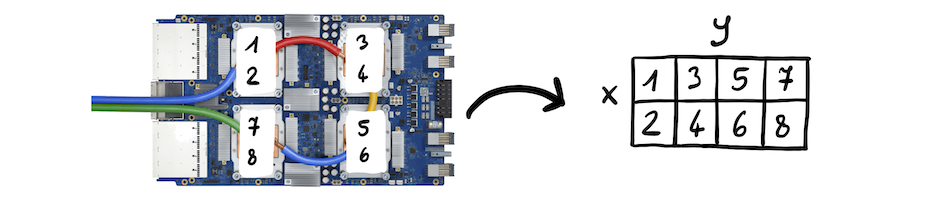

In [ ]:
axis_names = ('x', 'y')
mesh_devices = np.array(jax.devices()).reshape((2, 4))
assert len(axis_names) == mesh_devices.ndim
mesh_def = (mesh_devices, axis_names)
mesh_def

The mesh axis names are exactly the names of resources that named axes can be mapped to. But just creating a mesh definition won't make the resource names visible to `distr_matmul`:

In [ ]:
try:
  distr_matmul(x, x)
except Exception as e:
  print(e)

To introduce the resources in a scope, use the `with Mesh` context manager:

In [ ]:
from jax.sharding import Mesh

local = local_matmul(x, x)  # The local function doesn't require the mesh definition
with Mesh(*mesh_def):  # Makes the mesh axis names available as resources
  distr = distr_matmul(x, x)
np.testing.assert_allclose(local, distr)

Anyway, the best part of it is that specifying `axis_resources` **never changes program semantics**. You are free to experiment with different ways of partitioning your computation (just change the assignment of resources to named axes!) and even how the physical devices are organized in the mesh (by changing the construction of the NumPy array of devices). None of those things should have any significant influence on the results you get back (up to, for example, floating point inaccuracy), though of course some of them will achieve significantly better performance than the others.

`xmap` doesn't provide any automatic scheduling options at the moment, because the best schedule often has to be somewhat carefully matched to your program. We're considering adding support for that in the future, but it will take time.

> Once you map a logical axis to a mesh dimension, the size of that logical axis has to be divisible by the mesh dimension size.

### Is my data replicated? Or partitioned? Where is it?

Named axes also give us a neat way of reasoning about partitioning and replication. A value is partitioned over a mesh axis if and only if it has a named axis that has been mapped to that mesh axis in its shape. Otherwise, it will be replicated over all slices along that axis.

For example, assume that we're in an `xmap` that had `axis_resources={'a': 'x', 'b': 'y'}` specified (i.e. we are running the computation over a 2D mesh with `x` and `y` axes with sizes 2 and 3 respectively). Then:
* An array of type `f32[(5, 5), {}]` is completely replicated over the whole mesh. All devices store a local copy of the value.
* An array of type `f32[(6,), {'a': 8}]` is partitioned over mesh axis `x`, because it has `'a'` in its named shape, and `'a'` is mapped to `x`. It is replicated over mesh axis `y`. To put it differently, all devices in a slice of the mesh with the same `x` coordinate will store a local copy of a chunk of this array. But, mesh slices with different `x` coordinates will store different chunks of the data.
* An array of type `f32[(), {'a': 8, 'c': 7}]` is partitioned just like in the previous case: split over the `x` mesh axis and replicated over the `y` axis. Named dimensions with no resources specified are no different than positional dimensions when considering partitioning, so `'c'` has no influence on it.
* An array of type `f32[(), {'a': 8, 'b': 12}]` is completely partitioned over the whole mesh. Every device holds a distinct chunk of the data.

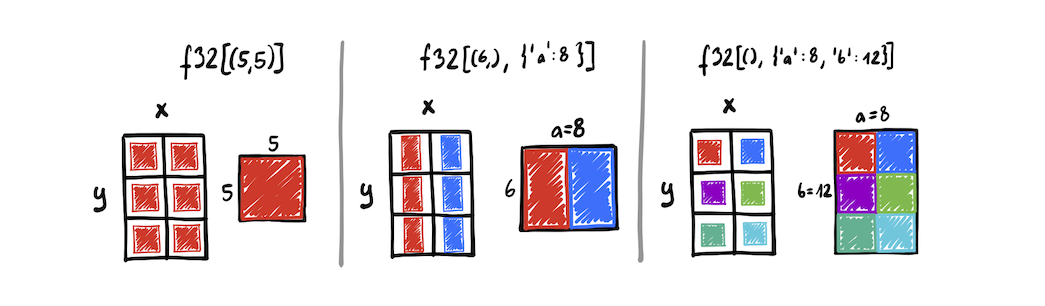

This also highlights one restriction: `xmap` won't complain if you specify `axis_resources={'a': 'x', 'b': 'x'}`, but consider how would an array with type `f32[(2, 8), {'a': 4, 'b': 12}]` be partitioned. If the size of the `x` mesh axis is 2, then we only have 2 devices, but we have 4 chunks to place (2 along `'a'` and 2 along `'b'`)! Now we can state it in full: **named axes mapped to the same resources can never both appear in the named shape of a single array**. But they can appear in named shapes of two distinct arrays, such as in this program:

In [ ]:
def sum_two_args(x: f32[(), {'a': 4}], y: f32[(), {'b': 12}]) -> f32[()]:
  return jnp.sum(x, axis='a') + jnp.sum(y, axis='b')

q = jnp.ones((4,), dtype=np.float32)
u = jnp.ones((12,), dtype=np.float32)
with Mesh(np.array(jax.devices()[:4]), ('x',)):
  v = xmap(sum_two_args,
           in_axes=(['a', ...], ['b', ...]),
           out_axes=[...],
           axis_resources={'a': 'x', 'b': 'x'})(q, u)
  print(v)

This program is valid, because `jnp.sum` eliminates the axes that cannot co-occur before the values are added.

> While the final release of `xmap` will ensure that you don't accidentally end up doing so, the current implementation _doesn't verify it_. Violating this restriction will result in _undefined behavior_.

### Why `axis_resources` and not a more direct mapping to hardware?

At this point you might wonder why go through the detour of introducing yet another concept of resource axes in the mix. For as long as you're interested in partitioning your computations over hardware, there is no good reason, but this mental framework is more flexible than that!

For example, there is one additional resource we all deal with: time! Just like a computation can be partitioned over multiple hardware devices, e.g. to lower its memory usage, the same thing can be achieved with a single accelerator that evaluates a chunk of the computation in multiple steps.

So, while hardware meshes are the only source of resource axes in JAX programs at the moment, we are planning to extend the whole system with other sources.

## Porting positional code to named code

In this section we will go over a few more real examples to show how `xmap` can help you implement and distribute various models.

> **This section is a work in progress**